In [1]:
import pandas as pd
import json
import os
import context_window_helper as cwh
import matplotlib.pyplot as plt
import numpy as np


In [2]:
filepath = r"C:\Users\Gert\repos\CS2_cheat_detection\DataConversionPipeline\test_data\killtest"
# filepath = r"C:\Users\Gert\Desktop\context_windows\not_cheater\cdata-notcheater-file_1-Player_6-kill_2.parquet"

match_ticks = pd.read_parquet(path=filepath+".parquet")
# match_ticks = pd.read_parquet(path=filepath)

# load json event data a list of tuples (str, pd.Dataframe)
def json_2_eventlist(filepath:str) -> list:
    with open(filepath, "r") as f:
        json_data = json.load(f)

    data = []

    for key, value in json_data.items():
        if isinstance(value, list):
            df = pd.DataFrame(value)
            data.append((key, df))

    return data

match_events = json_2_eventlist(filepath=filepath+".json")

In [3]:
# match_ticks.to_csv(r"C:\Users\Gert\repos\CS2_cheat_detection\DataConversionPipeline\test_data\test.csv", index=False)

In [4]:
ticks_before_kill = 896
ticks_after_kill = 128
context_window_size = ticks_before_kill + ticks_after_kill

context_window_vals = ["attacker_X", "attacker_Y", "attacker_Z", "attacker_vel", "attacker_pitch", "attacker_yaw", "attacker_pitch_delta", 
                       "attacker_yaw_delta", "attacker_pitch_head_delta", "attacker_yaw_head_delta", "attacker_flashed", "attacker_shot", "attacker_kill", "is_kill_headshot", "is_kill_through_smoke", 
                       "is_kill_wallbang", "attacker_midair", "attacker_weapon_knife", "attacker_weapon_auto_rifle", "attacker_weapon_semi_rifle", "attacker_weapon_pistol",
                       "attacker_weapon_grenade", "attacker_weapon_smg", "attacker_weapon_shotgun",
                       "victim_X", "victim_Y", "victim_Z", "victim_health", "victim_noise", "map_dust2", "map_mirage", "map_inferno", "map_train",
                       "map_nuke", "map_ancient", "map_vertigo", "map_anubis", "map_office", "map_overpass", "map_basalt", "map_edin", "map_italy", "map_thera", "map_mills"]

In [5]:
# # FAFO cell

# # idx = match_ticks[(match_ticks["flash_duration"] > 0)&(match_ticks["name"] == "Player_3")].index
# # vals = match_ticks.iloc[idx][["flash_duration", "tick"]]

# for i in match_ticks.columns:
    # print(i)

# for i in match_events:
    # print(i[0])

kills = match_events[24][1]
kills = kills[kills["attacker_steamid"] == "76561198045745648"]
kills["headshot"]
# kills = kills[kills["attacker_steamid"] == "Player_7"]
# kills
# tick = 60224
# match_ticks[match_ticks["tick"] == tick][["steamid", "team_name"]]
# match_events[0]
# # plt.plot(match_events[36][1]["attackerinair"])
# match_events[-2][1]["name"].tolist()

# test = match_ticks[(match_ticks['tick'] >= 7892)&(match_ticks['tick'] < 8916)&(match_ticks["steamid"] == "Player_3")]
# test
# match_ticks["steamid"].unique()
# weapons
# filepath = r"C:\Users\Gert\Desktop\parsed_data\no_cheater_present"
# maps = set()
# for i in range(478):
#     match_events = json_2_eventlist(filepath=filepath+f"\{str(i)}.json")
#     val = match_events[-1][1]["map"].tolist()[0]
#     maps.add(val)
#     print(f"\rProcessing i = {i}", end='', flush=True)
# maps
# plt.plot(match_ticks[(match_ticks["name"] == "Player_3")&(match_ticks["velocity"]<10000)]["velocity"])
# match_ticks["active_weapon_name"].unique()
# plt.plot(match_ticks[(match_ticks["name"] == "Player_3")]["yaw"])
# match_ticks[(match_ticks["velocity"] < 400)&(match_ticks["name"] == "Player_3")]["velocity"]


0     True
1    False
Name: headshot, dtype: bool

In [6]:
MDP = cwh.MatchDataProcessor(match_ticks, match_events, context_window_size)

In [18]:
# files_dir = r"C:\Users\Gert\Desktop\parsed_data\with_cheater_present"
# files = os.listdir(files_dir)

is_cheater_data = "cd"

player_death_idx = -1
weapon_fire_idx = -1
played_map = "de_mirage"
# played_map = match_events[-1][1]["map"].tolist()[0]

for idx, event in enumerate(match_events):
    if event[0] == "player_death":
        player_death_idx = idx
    if event[0] == "weapon_fire":
        weapon_fire_idx = idx
if player_death_idx == -1 or weapon_fire_idx == -1:
    raise Exception("not all events were found")
all_players = match_ticks["steamid"].unique().tolist()
for i in all_players:
    context_window = pd.DataFrame(columns=context_window_vals)
    attacker = i
    # is_attacker_cheater = attacker in match_events[-2][1]["steamid"].tolist()
    player_deaths = MDP.get_player_kills(str(attacker), player_death_idx)
    start_ticks, end_ticks = MDP.get_context_window_ticks(ticks_before_kill, ticks_after_kill, str(attacker), player_death_idx)

    for i in range(len(start_ticks)):
        attacker_team = MDP.get_player_team(start_ticks[i], end_ticks[i], attacker)
        victim = player_deaths.iloc[i]["user_steamid"]
        victim_team = MDP.get_player_team(start_ticks[i], end_ticks[i], victim)
        weapon_used = player_deaths.iloc[i]["weapon"]
        if weapon_used in MDP.weapon_grenade:
            continue

        # Skip teamkills
        if attacker_team == victim_team:
            continue

        # Check length of the context window and no ticks missing
        ticks = MDP.get_tick_values(start_ticks[i], end_ticks[i], attacker, "tick")
        if len(ticks) != context_window_size:
            gap = context_window_size - len(ticks)
            all_ticks = MDP.get_all_values_for_player(attacker, "tick")

            idx = all_ticks.index(start_ticks[i])
            end_ticks[i] = all_ticks[idx + 1024]

        (context_window["attacker_X"],
         context_window["attacker_Y"],
         context_window["attacker_Z"]) = MDP.get_player_coordinates(start_ticks[i], end_ticks[i], attacker, played_map)

        context_window["attacker_vel"] = MDP.get_player_velocity(start_ticks[i], end_ticks[i], attacker)
        context_window["attacker_pitch"] = MDP.get_player_pitch(start_ticks[i], end_ticks[i], attacker)
        context_window["attacker_yaw"] = MDP.get_player_yaw(start_ticks[i], end_ticks[i], attacker)
        context_window["attacker_pitch_delta"] = MDP.get_pitch_yaw_deltas("pitch", start_ticks[i], end_ticks[i], attacker)
        context_window["attacker_yaw_delta"] = MDP.get_pitch_yaw_deltas("yaw", start_ticks[i], end_ticks[i], attacker)

        context_window["attacker_pitch_head_delta"], context_window["attacker_yaw_head_delta"] = MDP.get_pitch_yaw_head_deltas(start_ticks[i], end_ticks[i], context_window_size, attacker, int(player_deaths.iloc[i]["user_steamid"]))

        context_window["attacker_flashed"] = MDP.get_is_player_flashed(start_ticks[i], end_ticks[i], attacker)
        context_window["attacker_shot"] = MDP.get_attacker_shots(start_ticks[i], end_ticks[i], attacker, weapon_fire_idx)
        (context_window["attacker_kill"], 
         context_window["is_kill_headshot"],
         context_window["is_kill_through_smoke"], 
         context_window["is_kill_wallbang"], 
         context_window["attacker_midair"]) = MDP.get_attacker_kill_data(start_ticks[i], end_ticks[i], attacker, player_death_idx)

        (context_window["attacker_weapon_knife"], 
         context_window["attacker_weapon_auto_rifle"], 
         context_window["attacker_weapon_semi_rifle"], 
         context_window["attacker_weapon_pistol"], 
         context_window["attacker_weapon_grenade"], 
         context_window["attacker_weapon_smg"], 
         context_window["attacker_weapon_shotgun"]) = MDP.get_attacker_weapon(start_ticks[i], end_ticks[i], attacker)

        (context_window["victim_X"],
         context_window["victim_Y"],
         context_window["victim_Z"]) = MDP.get_player_coordinates(start_ticks[i], end_ticks[i], int(victim), played_map)

        context_window["victim_health"] = MDP.get_player_health(start_ticks[i], end_ticks[i], int(victim))
        context_window["victim_noise"] = MDP.get_player_made_noise(start_ticks[i], end_ticks[i], attacker, weapon_fire_idx)

        (context_window["map_dust2"],
         context_window["map_mirage"],
         context_window["map_inferno"],
         context_window["map_train"],
         context_window["map_nuke"],
         context_window["map_ancient"],
         context_window["map_vertigo"],
         context_window["map_anubis"],
         context_window["map_office"],
         context_window["map_overpass"],
         context_window["map_basalt"],
         context_window["map_edin"],
         context_window["map_italy"],
         context_window["map_thera"],
         context_window["map_mills"]) = MDP.get_played_map(played_map)
    break



context_window.iloc[895]
        # Filename structure: c(cheater dataset)/n(not cheater dataset)_c(player cheater)/n(player not cheater)_filenr_playername_killnr.parquet
        # c_n = "c" if is_attacker_cheater else "n"
        # context_window.to_parquet(fr"C:\Users\Gert\Desktop\context_windows\{c_n}_NOTDONE_{attacker}_{i}.parquet", index=False)



attacker_X                    0.822128
attacker_Y                    0.106481
attacker_Z                    0.756108
attacker_vel                  0.000000
attacker_pitch                0.548803
attacker_yaw                  0.000807
attacker_pitch_delta          0.000000
attacker_yaw_delta            0.000000
attacker_pitch_head_delta     0.327728
attacker_yaw_head_delta       0.003418
attacker_flashed              0.000000
attacker_shot                 0.000000
attacker_kill                 1.000000
is_kill_headshot              0.000000
is_kill_through_smoke         1.000000
is_kill_wallbang              0.000000
attacker_midair               1.000000
attacker_weapon_knife         0.000000
attacker_weapon_auto_rifle    0.000000
attacker_weapon_semi_rifle    0.000000
attacker_weapon_pistol        0.000000
attacker_weapon_grenade       0.000000
attacker_weapon_smg           1.000000
attacker_weapon_shotgun       0.000000
victim_X                      0.694879
victim_Y                 

In [15]:
context_window = context_window.astype(np.float32)
context_window.to_csv(fr"C:\Users\Gert\repos\CS2_cheat_detection\DataConversionPipeline\test_data\killtest.csv", index=True)

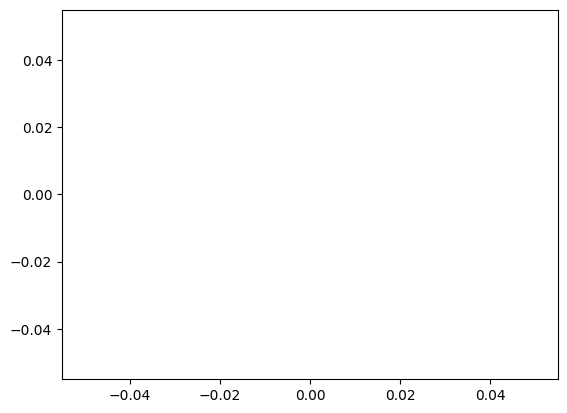

In [9]:
# print(player_deaths.iloc[7]["weapon"])

# plt.plot(context_window["attacker_pitch_head_delta"])
# plt.plot(context_window["attacker_yaw_head_delta"])
# plt.axvline(x=896)
# plt.show()

# plt.plot(context_window["attacker_kill"])
# plt.show()

plt.plot(context_window["victim_health"])
plt.show()

# plt.plot(context_window["attacker_weapon_auto_rifle"])
# plt.show()

# plt.plot(context_window["attacker_weapon_semi_rifle"])
# plt.show()

# plt.plot(context_window["attacker_weapon_pistol"])
# plt.show()

# plt.plot(context_window["attacker_weapon_grenade"])
# plt.show()

# plt.plot(context_window["attacker_weapon_smg"])
# plt.show()

# plt.plot(context_window["attacker_weapon_shotgun"])
# plt.show()



{'AK-47',
 'AUG',
 'AWP',
 'Bayonet',
 'Bowie Knife',
 'Butterfly Knife',
 'C4 Explosive',
 'CZ75-Auto',
 'Classic Knife',
 'Decoy Grenade',
 'Desert Eagle',
 'Dual Berettas',
 'FAMAS',
 'Falchion Knife',
 'Five-SeveN',
 'Flashbang',
 'Flip Knife',
 'G3SG1',
 'Galil AR',
 'Glock-18',
 'Gut Knife',
 'High Explosive Grenade',
 'Huntsman Knife',
 'Incendiary Grenade',
 'Karambit',
 'Kukri Knife',
 'M249',
 'M4A1-S',
 'M4A4',
 'M9 Bayonet',
 'MAC-10',
 'MAG-7',
 'MP5-SD',
 'MP7',
 'MP9',
 'Molotov',
 'Navaja Knife',
 'Negev',
 'Nomad Knife',
 None,
 'Nova',
 'P2000',
 'P250',
 'P90',
 'PP-Bizon',
 'Paracord Knife',
 'R8 Revolver',
 'SCAR-20',
 'SG 553',
 'SSG 08',
 'Sawed-Off',
 'Shadow Daggers',
 'Skeleton Knife',
 'Smoke Grenade',
 'Stiletto Knife',
 'Survival Knife',
 'Talon Knife',
 'Tec-9',
 'UMP-45',
 'USP-S',
 'Ursus Knife',
 'XM1014',
 'Zeus x27',
 'knife',
 'knife_t'}